In [1]:
from observational_fear.traces import TraceHandler
from observational_fear.config import BlockConfig, FreezeConfig

from pathlib import Path 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import Isomap, TSNE, MDS, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.pipeline import make_pipeline

from observational_fear.trajectories import TrajectoryVisulizer
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from sklearn.pipeline import Pipeline
from typing import Tuple
from tqdm.notebook import tqdm
from sklearn.base import clone

class DimentionalityReductionRunner:

    def __init__(self, df, compare_col, method="fit_transform", df_trials=None, cmaps=None):
        self.df = df
        self.method = method
        self.df_trials = df_trials
        self.fitter = self._fit_transform if self.method == "fit_transform" else self._fit_project
        self.compare_col = compare_col
        self.vis = TrajectoryVisulizer("")
        self.cmaps = cmaps if cmaps is not None else ("seismic", "seismic")


    def _fit_project(self, pipe):
        pipe = pipe.fit(self.df.values)
        res = pipe.transform(self.df_trials.values)
        df_res = pd.DataFrame(res, columns=["PC1", "PC2"], index=self.df_trials.index).reset_index().assign(prepost=lambda x: np.where(x.aligned < 0, "pre", "post"))
        return pipe, df_res

    def _fit_transform(self, pipe):
        res = pipe.fit_transform(self.df.values)
        df_res = pd.DataFrame(res, columns=["PC1", "PC2"], index=self.df.index).reset_index().assign(prepost=lambda x: np.where(x.aligned < 0, "pre", "post"))
        return pipe, df_res
    
    def _plot_trajectory(self, df_res, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        ax =  self.vis.plot_trajectories_pc_space_2d(df_res, cmaps=self.cmaps, compare_col=self.compare_col, ax=ax)
        ax.set_ylabel("Component 2")
        ax.set_xlabel("Component 1")
        return ax

    
    def _fit_transform_transposed(self, pipe):
        X = StandardScaler().fit_transform(self.df.values.T)
        res = pipe.fit_transform(X)
        df_res = pd.DataFrame(res, columns=["PC1", "PC2"], index=self.df.columns).reset_index()
        return pipe, df_res
        
    def run_single(self, pipe):
        figures = dict(trajectory=plt.figure(), neurons=plt.figure())
        trajectory_plot = figures["trajectory"].add_subplot(label="main")
        neurons_plot = figures["neurons"].add_subplot(label="main")

        _, df_neurons = self._fit_transform_transposed(clone(pipe.steps[-1][1]))
        pipe, df_res = self.fitter(pipe)
        self._plot_trajectory(df_res, ax=trajectory_plot)
        self._plot_neurons(df_neurons, ax=neurons_plot)
        return pipe, df_res, figures, df_neurons
    
    def run_multiple(self, pipes: Tuple[Tuple[str, Pipeline]]):
        out = {}
        for name, pipe in tqdm(pipes):
            pipe, df_res, figures, df_neurons = self.run_single(pipe)
            for f in figures.values():
                for ax in f.axes:
                    if ax.get_label() == "main":
                        ax.set_title(name)
            out[name] = dict(model=pipe, trajectories=df_res, figures=figures, neurons=df_neurons)
        return out

    def _plot_neurons(self, df_neurons, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        ax = sns.scatterplot(data=df_neurons, x="PC1", y="PC2", ax=ax, color="black")
        ax.set_ylabel("Component 2")
        ax.set_xlabel("Component 1")
        return ax
        


In [3]:
DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")
save_dir = DATA_DIR / "derived" / "tradjectories"
save_dir.mkdir(exist_ok=True)


d2map = LinearSegmentedColormap.from_list("", ["#fff4cc","#806404"])
d4map = LinearSegmentedColormap.from_list("", ["#fbe5d7","#843c0c"])

start_map = LinearSegmentedColormap.from_list("", ["#f9e5e6","#c00000"])
stop_map = LinearSegmentedColormap.from_list("", ["#e2f0d9","#395723"])

In [4]:
config_start = FreezeConfig(data_dir=DATA_DIR, session="day2", t_before=10, t_after=10, coreg_only=False, start_stop="start")
config_stop = FreezeConfig(data_dir=DATA_DIR, session="day2", t_before=10, t_after=10, coreg_only=False, start_stop="stop")

config_d2 = BlockConfig(data_dir=DATA_DIR, session="day2", t_before=10, t_after=10, coreg_only=True, block="US")
config_d4 = BlockConfig(data_dir=DATA_DIR, session="day4", t_before=10, t_after=10, coreg_only=True, block="US")

thandler_start = TraceHandler(config_start)
thandler_stop = TraceHandler(config_stop)

thandler_d2 = TraceHandler(config_d2)
thandler_d4 =TraceHandler(config_d4)


d2_trials = pd.concat({'day2': thandler_d2.aligned_wide}, names=['session'])
d2_avg = thandler_d2.aligned.pivot_table(index="aligned", columns="new_id", values="value")

d2_avg = pd.concat({'day2': d2_avg}, names=['session'])
d4_trials = pd.concat({'day4': thandler_d4.aligned_wide}, names=['session'])
d4_avg = thandler_d4.aligned.pivot_table(index="aligned", columns="new_id", values="value")
d4_avg = pd.concat({'day4': d4_avg}, names=['session'])
us_avg = pd.concat([d2_avg, d4_avg])
us_trials = pd.concat([d2_trials, d2_trials])


start_trials = pd.concat({'start': thandler_start.aligned_wide}, names=['start_stop'])
start_avg = thandler_start.aligned.pivot_table(index="aligned", columns="new_id", values="value")
start_avg = pd.concat({'start': start_avg}, names=['start_stop'])
stop_trials = pd.concat({'stop': thandler_stop.aligned_wide}, names=['start_stop'])
stop_avg = thandler_stop.aligned.pivot_table(index="aligned", columns="new_id", values="value")
stop_avg = pd.concat({'stop': stop_avg}, names=['start_stop'])
freeze_avg = pd.concat([start_avg, stop_avg])
freeze_trials = pd.concat([start_trials, stop_trials])

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")
c:\users\roryl\repos\observational-fear\observational_fear\align.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traces["time"].values, events, time_before=t_before, time_after=t_after
c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [5]:
pipes = (
    ("TSNE Normalized", make_pipeline(StandardScaler(), TSNE(n_components=2, perplexity=13, init="random", learning_rate="auto"))),
    # ("UMAP Norm", make_pipeline(StandardScaler(), UMAP(n_components=2))),
    # ("TSNE", make_pipeline(TSNE(n_components=2))),
    ("ISOMAP Normalized", make_pipeline(StandardScaler(), Isomap(n_components=2, n_neighbors=25))),
    # ("ISOMAP", make_pipeline(Isomap(n_components=2))),
    # ("MDS Normalized", make_pipeline(StandardScaler(), MDS(n_components=2))),
    # ("MDS", make_pipeline(MDS(n_components=2))),
    # ("Spectral Embedding Normalized", make_pipeline(StandardScaler(), SpectralEmbedding(n_components=2))),
    # ("Spectral Embedding", make_pipeline(SpectralEmbedding(n_components=2))),
    # ("Locally Linear Embedding Normalized", make_pipeline(StandardScaler(), LocallyLinearEmbedding(n_components=2, n_neighbors=10))),
    # ("Locally Linear Embedding", make_pipeline(LocallyLinearEmbedding(n_components=2, n_neighbors=10))),
)

  0%|          | 0/2 [00:00<?, ?it/s]

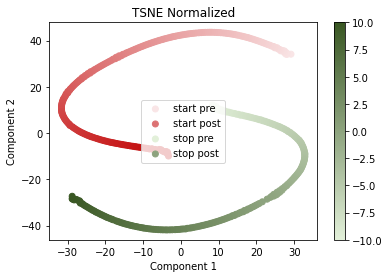

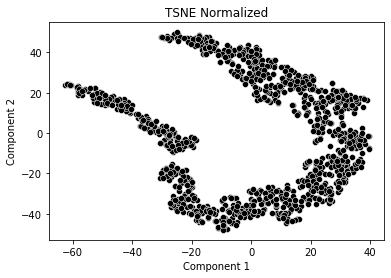

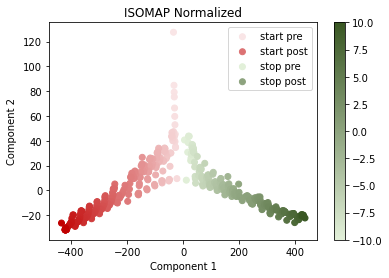

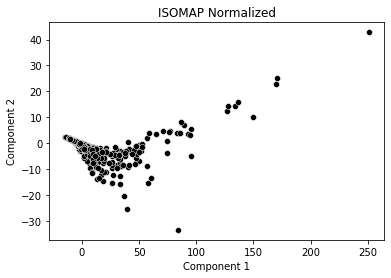

In [6]:
freeze_runner = DimentionalityReductionRunner(
    freeze_avg, compare_col="start_stop", method="fit_transform", 
    df_trials=freeze_trials, cmaps=(start_map, stop_map)
    )

res = freeze_runner.run_multiple(pipes)
out_dir = save_dir / "Non Linear freeze start stop"

for name, results in res.items():
    results["figures"]["trajectory"].savefig(out_dir / f"{name} Trajectory.svg")
    results["figures"]["neurons"].savefig(out_dir / f"{name} Neurons.svg")

  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\sklearn\manifold\_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


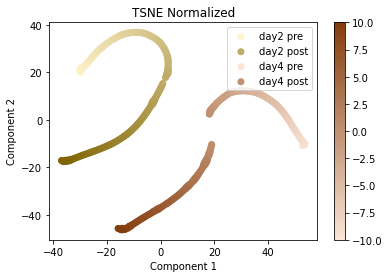

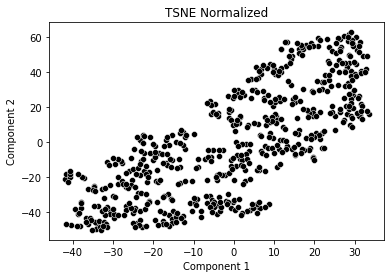

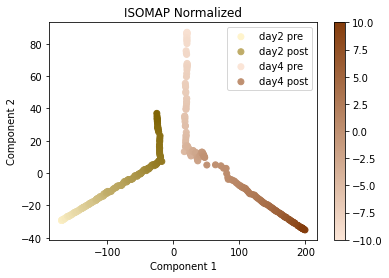

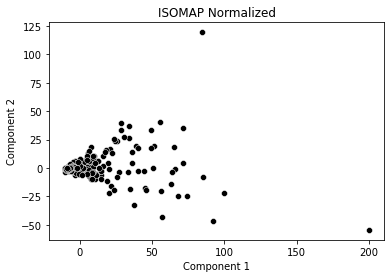

In [8]:
us_runner = DimentionalityReductionRunner(
    us_avg, compare_col="session", method="fit_transform", 
    df_trials=us_trials, cmaps=(d2map, d4map)
    )

res = us_runner.run_multiple(pipes)
out_dir = save_dir / "Non Linear US Combined"


for name, results in res.items():
    results["figures"]["trajectory"].savefig(out_dir / f"{name} Trajectory.svg")
    results["figures"]["neurons"].savefig(out_dir / f"{name} Neurons.svg")